# Predicting Bike Rentals
---
Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](http://www.up.pt/) compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

Here are the descriptions for the relevant columns:

- `instant` - A unique sequential ID number for each row
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred
- `yr` - The year the rentals occurred
- `mnth` - The month the rentals occurred
- `hr` - The hour the rentals occurred
- `holiday` - Whether or not the day was a holiday
- `weekday` - The day of the week (as a number, 0 to 7)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather (as a categorical variable)
- `temp` - The temperature, on a 0-1 scale
- `atemp` - The adjusted temperature
- `hum` - The humidity, on a 0-1 scale
- `windspeed` - The wind speed, on a 0-1 scale
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, We'll create a few different machine learning models and evaluate their performance.

### Prerequisites

In [1]:
#Importing the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Plot settings
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
#Importing the data set
bike_rentals=pd.read_csv('bike_rental_hour.csv',parse_dates=['dteday'])
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
#Checking for null values
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

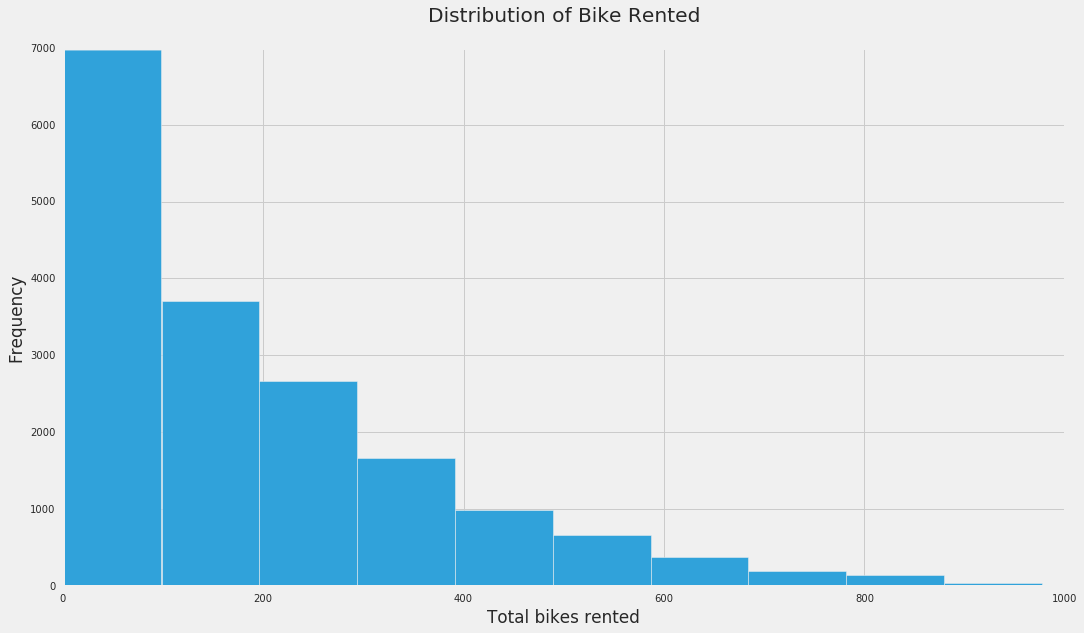

In [4]:
#Checking the distribution of total rentals using a histogram
plt.figure(figsize=(16,9))
plt.hist(bike_rentals['cnt'])
plt.title('Distribution of Bike Rented',y=1.04)
plt.xlabel('Total bikes rented')
plt.ylabel('Frequency')

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the `hr` column  contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [5]:
#Creating a function which assigns the respective time period
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals['time_label']=bike_rentals['hr'].apply(assign_label)
bike_rentals.drop('hr',axis=1,inplace=True)

Before we can begin applying machine learning algorithms, we'll need to split the data into training and testing sets. The reason behind this is if we train an algorithm on the training data, then evaluate its performance on the same data, we can get an unrealistically low error value, due to overfitting.

In [6]:
train=bike_rentals.sample(frac=.8,random_state=1).copy()
test=bike_rentals.loc[~bike_rentals.index.isin(train.index)].copy()

In [7]:
#Finding columns which is correlated to cnt
abs_cor=bike_rentals.corr()['cnt'].abs().sort_values(ascending=False)
abs_cor

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
time_label    0.378318
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

### Machine Learning

After spliting and fixing the data for machine learning, we are set to go. Based on seeing some values of the `cnt` column, we will use Mean Squared Error (MSE) and the Root Mean Square Error (RMSE) to measure the error of the model.

Features that we will use are columns which have greater than 0.3 R-value to the column `cnt`. Should the predicted model is biased, we will tweak the features again. We will also exclude `cnt`(our target), `casual`, `dteday`, and `registered`. 

#### 1. Linear Regression

In [8]:
#Sorting the features
features=abs_cor[abs_cor>0.3].index.tolist()
for i in ['cnt','casual','registered']:
    features.remove(i)
features

['temp', 'atemp', 'time_label', 'hum']

In [9]:
#Importing modules for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Creating linear regression model
lr=LinearRegression()
lr.fit(train[features],train['cnt'])
predict=lr.predict(test[features])
predicttrain=lr.predict(train[features])

#Measuring the errors
mse=mean_squared_error(test['cnt'],predict)
rmse=np.sqrt(mse)
tmse=mean_squared_error(train['cnt'],predicttrain)
trmse=np.sqrt(tmse)
print('Train\'s MSE value is {a} and RMSE is {b}'.format(a=tmse,b=trmse))
print('Test\'s MSE value is {a} and RMSE is {b}'.format(a=mse,b=rmse))

Train's MSE value is 21491.900735742674 and RMSE is 146.6011621227563
Test's MSE value is 20560.061181883826 and RMSE is 143.3877999757435


It seems like both of the value seems a little too high, we can try adding more features and see if it decreases. What if we are using all of the features except those we have removed.

In [10]:
#Sorting the features
features=abs_cor.index.tolist()
for i in ['cnt','casual','registered']:
    features.remove(i)
    
#Creating linear regression model
lr=LinearRegression()
lr.fit(train[features],train['cnt'])
predict=lr.predict(test[features])
predicttrain=lr.predict(train[features])

#Measuring the errors
mse=mean_squared_error(test['cnt'],predict)
rmse=np.sqrt(mse)
tmse=mean_squared_error(train['cnt'],predicttrain)
trmse=np.sqrt(tmse)
print('Train\'s MSE value is {a} and RMSE is {b}'.format(a=tmse,b=trmse))
print('Test\'s MSE value is {a} and RMSE is {b}'.format(a=mse,b=rmse))

Train's MSE value is 19415.649025642837 and RMSE is 139.34004817583076
Test's MSE value is 18855.0027571111 and RMSE is 137.31351993562433


We can see that the MSE and the RMSE value decreases as the number of feature increases.  The training and validation MSE's are very close togther. This suggest our model is not overfitting. This model should be better at predicting the total bikes rented in a day, but the error is still relatively high. probably due to the fact that there are a few very high rental counts and these large errors are penalized more with MSE.

#### 2. Decision Tree Regressor
We will try to see if using decision tree regression is better than using just linear regression in terms of MSE and RMSE.

In [11]:
#Importing the module
from sklearn.tree import DecisionTreeRegressor

#Trying to see which max_depth value have the least error difference
def mx_depthtest(x):
    temp=[]
    for i in range(1,x+1):
        tr=DecisionTreeRegressor(max_depth=i,random_state=1)
        tr.fit(train[features],train['cnt'])
        tra_pred=tr.predict(train[features])
        tes_pred=tr.predict(test[features])
        mse_tra=mean_squared_error(train['cnt'],tra_pred)
        mse_tes=mean_squared_error(test['cnt'],tes_pred)
        temp.append(abs(mse_tra-mse_tes))
    return (temp.index(min(temp)))+1

#Trying to find the optimal value for min_samples_leaftest
op_max_depth=mx_depthtest(50)

In [12]:
#Trying to see which min_samples_leaf value have the least error difference with optimal depth
def ms_test(x):
    temp=[]
    for i in range(1,x+1):
        tr=DecisionTreeRegressor(max_depth=op_max_depth,min_samples_leaf=i,random_state=1)
        tr.fit(train[features],train['cnt'])
        tra_pred=tr.predict(train[features])
        tes_pred=tr.predict(test[features])
        mse_tra=mean_squared_error(train['cnt'],tra_pred)
        mse_tes=mean_squared_error(test['cnt'],tes_pred)
        temp.append(abs(mse_tra-mse_tes))
    return (temp.index(min(temp)))+1

#Trying to find the optimal value for min_samples_leaftest
op_ms=ms_test(50)

In [13]:
#Creating the model with optimal value
tr=DecisionTreeRegressor(max_depth=op_max_depth,min_samples_leaf=op_ms,random_state=1)
tr.fit(train[features],train['cnt'])
predict=tr.predict(test[features])
predicttrain=tr.predict(train[features])

#Measuring the errors
mse=mean_squared_error(test['cnt'],predict)
rmse=np.sqrt(mse)
tmse=mean_squared_error(train['cnt'],predicttrain)
trmse=np.sqrt(tmse)
print('Train\'s MSE value is {a} and RMSE is {b}'.format(a=tmse,b=trmse))
print('Test\'s MSE value is {a} and RMSE is {b}'.format(a=mse,b=rmse))

Train's MSE value is 14685.403827825277 and RMSE is 121.18334798075715
Test's MSE value is 14645.48272849112 and RMSE is 121.01852225379022


After using a Decision Tree Regressor with maximum depth of 6 and minimum samples for each leaf with 39, we can see the difference between train and test respective MSE and RMSE values are low. This is a good omen that our model is not overfitting. However, let us try using Random Forrest Regression to try getting both values down!

#### 3. Random Forrest Regressor

In [14]:
#Importing the module
from sklearn.ensemble import RandomForestRegressor

#Trying to see which max_depth value have the least error difference
def mx_depthtest(x):
    temp=[]
    for i in range(1,x+1):
        tr=RandomForestRegressor(max_depth=i,random_state=1)
        tr.fit(train[features],train['cnt'])
        tra_pred=tr.predict(train[features])
        tes_pred=tr.predict(test[features])
        mse_tra=mean_squared_error(train['cnt'],tra_pred)
        mse_tes=mean_squared_error(test['cnt'],tes_pred)
        temp.append(abs(mse_tra-mse_tes))
    return (temp.index(min(temp)))+1

#Trying to find the optimal value for min_samples_leaftest
op_max_depth=mx_depthtest(50)

In [15]:
#Trying to see which min_samples_leaf value have the least error difference with optimal depth
def ms_test(x):
    temp=[]
    for i in range(1,x+1):
        tr=RandomForestRegressor(max_depth=op_max_depth,min_samples_leaf=i,random_state=1)
        tr.fit(train[features],train['cnt'])
        tra_pred=tr.predict(train[features])
        tes_pred=tr.predict(test[features])
        mse_tra=mean_squared_error(train['cnt'],tra_pred)
        mse_tes=mean_squared_error(test['cnt'],tes_pred)
        temp.append(abs(mse_tra-mse_tes))
    return (temp.index(min(temp)))+1

#Trying to find the optimal value for min_samples_leaftest
op_ms=ms_test(100)

In [16]:
#Trying to see which n_estimators value have the least error difference with optimal depth
def tree_test(x):
    temp=[]
    for i in range(1,x+1):
        tr=RandomForestRegressor(n_estimators=i,max_depth=op_max_depth,min_samples_leaf=op_ms,random_state=1)
        tr.fit(train[features],train['cnt'])
        tra_pred=tr.predict(train[features])
        tes_pred=tr.predict(test[features])
        mse_tra=mean_squared_error(train['cnt'],tra_pred)
        mse_tes=mean_squared_error(test['cnt'],tes_pred)
        temp.append(abs(mse_tra-mse_tes))
    return (temp.index(min(temp)))+1

#Trying to find the optimal value for min_samples_leaftest
op_tree=tree_test(50)

In [17]:
#Modelling the random forrest
tr=RandomForestRegressor(n_estimators=op_tree,max_depth=op_max_depth,min_samples_leaf=op_ms,random_state=1)
tr.fit(train[features],train['cnt'])
predict=tr.predict(test[features])
predicttrain=tr.predict(train[features])

#Measuring the errors
mse=mean_squared_error(test['cnt'],predict)
rmse=np.sqrt(mse)
tmse=mean_squared_error(train['cnt'],predicttrain)
trmse=np.sqrt(tmse)
print('Train\'s MSE value is {a} and RMSE is {b}'.format(a=tmse,b=trmse))
print('Test\'s MSE value is {a} and RMSE is {b}'.format(a=mse,b=rmse))

Train's MSE value is 14214.192012760843 and RMSE is 119.22328636957145
Test's MSE value is 14174.60180881309 and RMSE is 119.0571367403613


After using the optimized version of Random Forest Regressor with maximum depth of 6, minimum samples per leaf of 10 and number of estimators of 15, we can see that there is indeed a decrease in the both MSE and RMSE value. 

Let's try and visualize the `cnt` from the test sample and the predicted value!

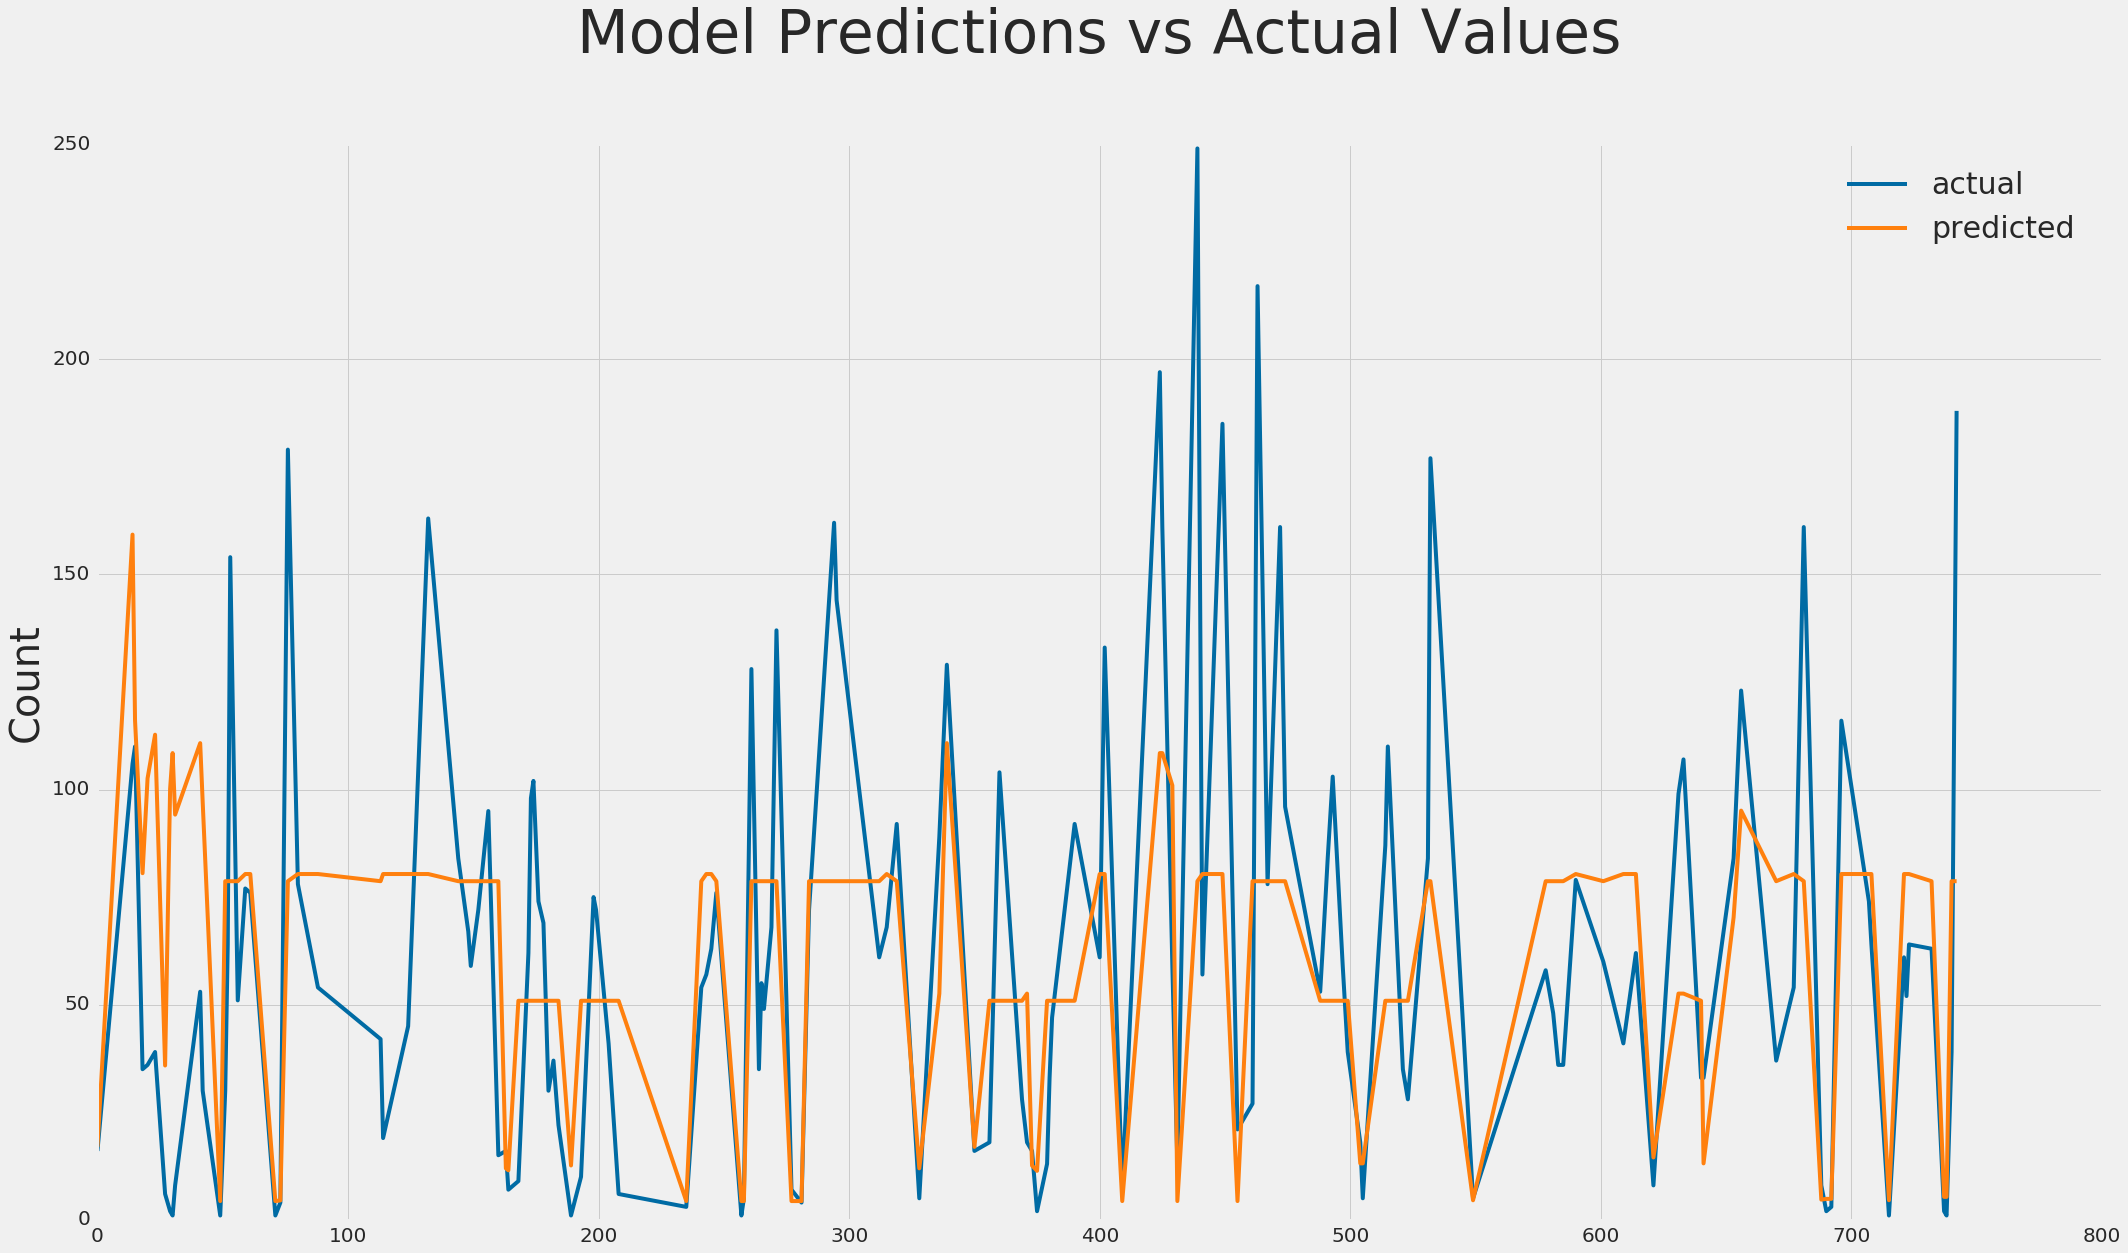

In [18]:
#Appending the result of predictions into the test dataframe
test['predictions'] = predict

#Changing the figure size and Setting the Color
plt.figure(figsize=(32,18))
cb_dark_blue = (0/255,107/255,164/255)
cb_orange = (255/255, 128/255, 14/255)

#Plotting
x = test.index
plt.plot(x[:150], test['cnt'][:150], label='actual',color=cb_dark_blue)
plt.plot(x[:150], test['predictions'][:150], label='predicted',color=cb_orange)

#Plot Settings
plt.xlim(0,)
plt.ylabel('Count',fontsize=40)
plt.legend(fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Model Predictions vs Actual Values',y=1.08,fontsize=60)
plt.show()

### Conclusion
It can be concluded that the best model to use for this particular sample is Random Forest Regression with maximum depth of 6, minimum samples per leaf of 10 and 15 estimators. That being said, from the start until the end, the model does not overfit the train and test sets, that is because we are choosing the best value for each model's parameter by looping and calculating the difference of the MSE 50 times.